In [2]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import scipy.stats as st

print(np.random.rand(25))


[0.6343927  0.38507048 0.38039593 0.97442194 0.46803758 0.04586697
 0.0151639  0.54081283 0.09453908 0.30335797 0.49559173 0.01541332
 0.69907023 0.61535394 0.91543477 0.55721335 0.5153341  0.65486742
 0.87931728 0.92006032 0.9918421  0.89734576 0.06510291 0.49482525
 0.41420985]


In [3]:
print(np.zeros((10,5) ))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [4]:
# You'll see why we call it `_slow` soon :)
def simulate_loan_repayments_slow(N, r=0.05, repayment_full=25_000.0,
                                  repayment_part=12_500.0):
    repayment_sims = np.zeros(N)
    for i in range(N):
        x = np.random.rand()  # Draw a random number

        # Full repayment 75% of time
        if x < 0.75:
            repaid = repayment_full
        elif x < 0.95:
            repaid = repayment_part
        else:
            repaid = 0.0

        repayment_sims[i] = (1 / (1 + r)) * repaid

    return repayment_sims


In [5]:
def simulate_loan_repayments(N, r=0.05, repayment_full=25_000.0,
                             repayment_part=12_500.0):
    """
    Simulate present value of N loans given values for discount rate and
    repayment values
    """
    random_numbers = np.random.rand(N)

    # start as 0 -- no repayment
    repayment_sims = np.zeros(N)

    # adjust for full and partial repayment
    partial = random_numbers <= 0.20
    repayment_sims[partial] = repayment_part

    full = ~partial & (random_numbers <= 0.95)
    repayment_sims[full] = repayment_full

    repayment_sims = (1 / (1 + r)) * repayment_sims

    return repayment_sims

def simulate_year_of_loans(N=250, K=1000):

    # Create array where we store the values
    avg_repayments = np.zeros(K)
    for year in range(K):

        repaid_year = 0.0
        n_loans = simulate_loan_repayments(N)
        avg_repayments[year] = n_loans.mean()

    return avg_repayments

loan_repayment_outcomes = simulate_year_of_loans(N=250)

# Think about why we use the 5th percentile of outcomes to
# compute when we are profitable 95% of time
lro_5 = np.percentile(loan_repayment_outcomes, 5)

print("The largest loan size such that we were profitable 95% of time is")
print(lro_5)

The largest loan size such that we were profitable 95% of time is
19523.809523809523


In [6]:
def simulate_loan_lifetime(monthly_payment):

    # Create arrays to store outputs
    payments = np.zeros(12)
    # Note: dtype 'U12' means a string with no more than 12 characters
    statuses = np.array(4*["repaying", "delinquency", "default"], dtype="U12")

    # Everyone is repaying during their first month
    payments[0] = monthly_payment
    statuses[0] = "repaying"

    for month in range(1, 12):
        rn = np.random.rand()

        if (statuses[month-1] == "repaying"):
            if rn < 0.85:
                payments[month] = monthly_payment
                statuses[month] = "repaying"
            elif rn < 0.95:
                payments[month] = 0.0
                statuses[month] = "delinquency"
            else:
                payments[month] = 0.0
                statuses[month] = "default"
        elif (statuses[month-1] == "delinquency"):
            if rn < 0.25:
                payments[month] = monthly_payment
                statuses[month] = "repaying"
            elif rn < 0.85:
                payments[month] = 0.0
                statuses[month] = "delinquency"
            else:
                payments[month] = 0.0
                statuses[month] = "default"
        else:  # Default -- Stays in default after it gets there
            payments[month] = 0.0
            statuses[month] = "default"

    return payments, statuses


#Exercise 1

In [7]:

def normal_mean():
    randomNums = np.zeros(10_000)
    for n in range(10_000):
        randomNums[n] = np.random.normal()
    return np.mean(randomNums)

simNumber = 100
simArr = np.zeros(simNumber)
for sim in range(simNumber):   
    simArr[sim] = normal_mean()

print(np.mean(simArr))


-0.0015815149247167609


In [8]:

def variance():
    randomNums = np.zeros(10_000)
    for n in range(10_000):
        randomNums[n] = 0 - np.random.normal()
    return np.var(randomNums)

print(variance())

1.004177104238604


#Exercise 2

In [9]:
# 1. State description
state_values = ["repaying", "delinquency", "default"]

# 2. Transition probabilities: encoded in a matrix (2d-array) where element [i, j]
# is the probability of moving from state i to state j
P = np.array([[0.85, 0.1, 0.05], [0.25, 0.6, 0.15], [0, 0, 1]])

# 3. Initial distribution: assume loans start in repayment
x0 = np.array([1, 0, 0])
mc = qe.markov.MarkovChain(P, state_values)
print(mc.simulate(12, init="repaying"))

x = x0
for t in range(10):
    print(f"At time {t} the distribution is {x}")
    x = mc.P.T @ x

print(mc.stationary_distributions)

['repaying' 'repaying' 'delinquency' 'repaying' 'repaying' 'repaying'
 'repaying' 'repaying' 'delinquency' 'delinquency' 'delinquency'
 'delinquency']
At time 0 the distribution is [1 0 0]
At time 1 the distribution is [0.85 0.1  0.05]
At time 2 the distribution is [0.7475 0.145  0.1075]
At time 3 the distribution is [0.671625 0.16175  0.166625]
At time 4 the distribution is [0.61131875 0.1642125  0.22446875]
At time 5 the distribution is [0.56067406 0.15965937 0.27966656]
At time 6 the distribution is [0.5164878  0.15186303 0.33164917]
At time 7 the distribution is [0.47698039 0.1427666  0.38025302]
At time 8 the distribution is [0.44112498 0.133358   0.42551703]
At time 9 the distribution is [0.40829573 0.1241273  0.46757697]
[[0. 0. 1.]]


#Exercise 3

In [13]:
alpha = 0.05
phi = 0.10

earnerIncome = 10
nonearnerIncome = 1

x0 = np.array([900_000, 100_000])
employmentDyanmics = np.array([[1-alpha, alpha],[phi, 1-phi]])


state_values = ['employed', 'unemployed']
P = np.array([[0.95, 0.05],[.10, 0.90]])
x0 = np.array([1, 0])

mc = qe.markov.MarkovChain(P, state_values)

print(mc.simulate(12, init='employed'))
x = x0
for t in range(30):
    x = mc.P.T @ x

print(mc.simulate(1, init='unemployed'))

y = np.flip(x0)
for t in range(1000):
    y = mc.P.T @ y
print(y)

['employed' 'employed' 'employed' 'employed' 'employed' 'employed'
 'employed' 'employed' 'unemployed' 'unemployed' 'unemployed' 'unemployed']
['unemployed']
[0.66666667 0.33333333]


#Exercse 4

In [51]:
def plot_gamma(k, theta, x, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    # scipy refers to the rate parameter beta as a scale parameter
    pdf_x = st.gamma(k, scale=theta).pdf(x)
    ax.plot(x, pdf_x, label=f"k = {k}  theta = {theta}")

    return ax

In [46]:
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import gamma

import matplotlib.pyplot as plt

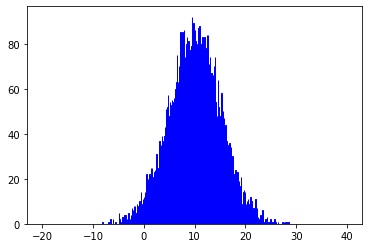

In [70]:
assetOneMu = 10
assetOneStd = 5

assetTwoK = 5.3
assetTwoStd = 2

assetThreeK = 5
assetThreeStd = 2

x = np.arange(-10, 30,1)
np.random.seed(10)

#creating a vector containing 10000
#normally distributed random numbers
y = norm.rvs(assetOneMu, assetOneStd, 10000)

#creating bin
bin = np.arange(-20,40,0.1)

plt.hist(y, bins=bin, edgecolor='blue') 
plt.show()

In [104]:
print(f'The mean return of asset one is ${np.mean(y):.2f}')
print(f'The median return of asset one is ${np.median(y):.2f}')
print(f'The variation is {stats.variation(y):.2f}')

The mean return of asset one is $10.03
The median return of asset one is $10.07
The variation is 0.49


In [105]:
alpha = 5.3
loc = 2
beta = 22
data = stats.gamma.rvs(alpha, loc=loc, size=1000)    
mean = (np.mean(data))
median = (np.median(data))
var = stats.variation(data)

print(f'The mean return of asset two is {mean:.2f}')
print(f'The median return of asset two is {median:.2f}')
print(f'The variation of asset two is {var:.2f}')


The mean return of asset two is 7.30
The median return of asset two is 6.96
The variation of asset two is 0.32


In [106]:
alpha = 5
loc = 2
data = stats.gamma.rvs(alpha, loc=loc, size=1000)    
mean = (np.mean(data))
median = (np.median(data))
var = stats.variation(data)


print(f'The mean return of asset three is {mean:.2f}')
print(f'The median return of asset three is {median:.2f}')
print(f'The variation of asset two is {var:.2f}')


The mean return of asset three is 7.11
The median return of asset three is 6.87
The variation of asset two is 0.30


Asset One has the highest mean and median returns

Asset three has the highest variation

I would choose asset one, as its returns are substantially higher than either of the other assets.

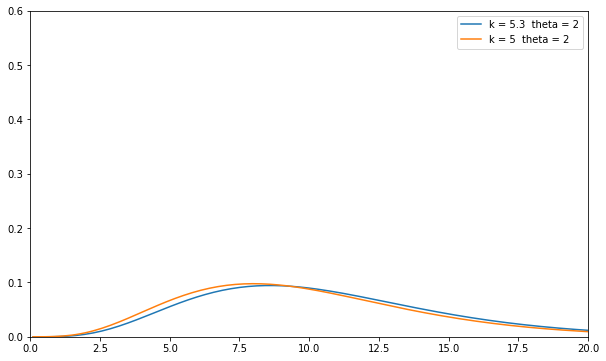

In [80]:
def plot_gamma(k, theta, x, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    # scipy refers to the rate parameter beta as a scale parameter
    pdf_x = st.gamma(k, scale=theta).pdf(x)
    ax.plot(x, pdf_x, label=f"k = {k}  theta = {theta}")

    return ax


fig, ax = plt.subplots(figsize=(10, 6))
x = np.linspace(0.1, 20, 130)
plot_gamma(5.3, 2, x, ax)
plot_gamma(5, 2, x, ax)


ax.set_ylim((0, 0.6))
ax.set_xlim((0, 20))
ax.legend()

Asset 2